In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from data_stream_simulator import DataStreamSimulator
from algorithms import (
    EWMA, SlidingWindowDensityEstimation, StreamingHampelFilter,
    ADWIN, RankedSlidingWindowAnomalyDetection, OMLADEWMAStreaming, MovingZScore
)
import ipywidgets as widgets
from IPython.display import display, clear_output

Anomaly detected at Timestamp 99: Value=0.19822864234414422


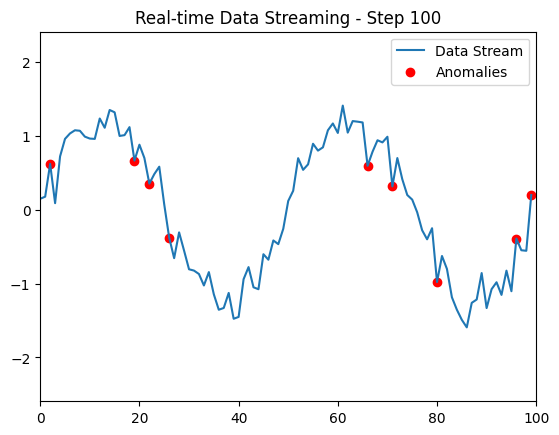

In [3]:
# Initialize the DataStreamSimulator
simulator = DataStreamSimulator(amplitude=1, period=50, seasonality_amplitude=0.3,
                                 seasonality_period=50, noise_level=0.2, stream_length=100)

# Create the figure and axis for the plot
fig, ax = plt.subplots()

# Initialize empty lists for x and y data and anomalies
x_data = []
y_data = []
anomaly_x = []
anomaly_y = []

# Create a dropdown for selecting the detector
detector_dropdown = widgets.Dropdown(
    options=[
        'EWMA', 'StreamingHampelFilter', 'ADWIN', 'SlidingWindowDensityEstimation',
        'RankedSlidingWindowAnomalyDetection', 'OMLADEWMAStreaming', 'MovingZScore'
    ],
    description='Select Detector:',
)

# Create parameter input fields for each detector
param_boxes = {
    'EWMA': [widgets.FloatSlider(value=0.3, min=0.0, max=1.0, step=0.01, description='Alpha:'),
             widgets.FloatSlider(value=3, min=0, max=10, step=0.1, description='Threshold:')],
    
    'StreamingHampelFilter': [widgets.IntSlider(value=7, min=1, max=20, description='Window Size:'),
                              widgets.FloatSlider(value=3, min=0, max=10, step=0.1, description='Number of Sigmas:')],
    
    'ADWIN': [widgets.FloatSlider(value=0.001, min=0.0001, max=0.01, step=0.0001, description='Delta:')],
    
    'SlidingWindowDensityEstimation': [widgets.IntSlider(value=50, min=1, max=100, description='Window Size:'),
                                        widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Bandwidth:'),
                                        widgets.FloatSlider(value=0.01, min=0.0, max=1.0, step=0.01, description='Density Threshold:')],
    
    'RankedSlidingWindowAnomalyDetection': [widgets.IntSlider(value=50, min=1, max=100, description='Window Size:'),
                                             widgets.FloatSlider(value=0.95, min=0.0, max=1.0, step=0.01, description='Rank Threshold:')],
    
    'OMLADEWMAStreaming': [widgets.FloatSlider(value=3, min=0, max=10, step=0.1, description='Threshold:'),
                           widgets.FloatSlider(value=0.3, min=0.0, max=1.0, step=0.01, description='Alpha:')],
    
    'MovingZScore': [widgets.IntSlider(value=20, min=1, max=100, description='Window Size:'),
                     widgets.FloatSlider(value=3, min=0, max=10, step=0.1, description='Threshold:')],
}

# Create a function to update parameter boxes based on the selected detector
def update_params(detector):
    for box in param_boxes.values():
        for b in box:
            b.close()
    for param_box in param_boxes[detector]:
        display(param_box)

# Link the dropdown to the update function
detector_dropdown.observe(lambda change: update_params(change['new']), names='value')

display(detector_dropdown)

# Button to start the simulation
start_button = widgets.Button(description="Start Simulation")

def start_simulation(b):
    # Reset data lists
    global x_data, y_data, anomaly_x, anomaly_y
    x_data = []
    y_data = []
    anomaly_x = []
    anomaly_y = []

    # Get parameters based on selected detector
    selected_detector = detector_dropdown.value
    params = [box.value for box in param_boxes[selected_detector]]

    # Initialize the selected anomaly detector
    if selected_detector == 'EWMA':
        anomaly_detector = EWMA(alpha=params[0], threshold=params[1])
    elif selected_detector == 'StreamingHampelFilter':
        anomaly_detector = StreamingHampelFilter(window_size=params[0], n_sigmas=params[1])
    elif selected_detector == 'ADWIN':
        anomaly_detector = ADWIN(delta=params[0])
    elif selected_detector == 'SlidingWindowDensityEstimation':
        anomaly_detector = SlidingWindowDensityEstimation(window_size=params[0], bandwidth=params[1], density_threshold=params[2])
    elif selected_detector == 'RankedSlidingWindowAnomalyDetection':
        anomaly_detector = RankedSlidingWindowAnomalyDetection(window_size=params[0], rank_threshold=params[1])
    elif selected_detector == 'OMLADEWMAStreaming':
        anomaly_detector = OMLADEWMAStreaming(threshold=params[0], alpha=params[1])
    elif selected_detector == 'MovingZScore':
        anomaly_detector = MovingZScore(window_size=params[0], threshold=params[1])

    # Process the data stream
    for timestamp, point in simulator.stream_data():
        x_data.append(timestamp)  # Add the new x data point (timestamp)
        y_data.append(point)  # Add the new y data point (simulated value)

        # Check for anomalies
        anomaly = anomaly_detector.update(point)

        if anomaly:  # Assuming anomaly is a boolean
            anomaly_x.append(timestamp)
            anomaly_y.append(point)
            print(f"Anomaly detected at Timestamp {timestamp}: Value={point}")

        # Update the plot
        ax.clear()  # Clear the previous plot
        ax.plot(x_data, y_data, label="Data Stream")  # Plot the data
        ax.scatter(anomaly_x, anomaly_y, color='red', label="Anomalies")  # Plot anomalies as red dots

        ax.set_xlim(0, 100)  # Fix the x-axis limits for consistent scaling
        ax.set_ylim(min(y_data) - 1, max(y_data) + 1)  # Set y-axis limits to the data range
        ax.set_title(f"Real-time Data Streaming - Step {timestamp + 1}")
        ax.legend()

        display(fig)  # Display the updated figure
        clear_output(wait=True)  # Clear the output to display a single plot at a time

        plt.pause(0.1)  # Pause for a brief period to simulate real-time updates

        if timestamp >= 100:
            break

start_button.on_click(start_simulation)
display(start_button)
